In [44]:
import numpy as np
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator
import scipy.ndimage
import coordinate_transform_functions as ct
from _globals import *
from tqdm import tqdm
from astropy.table import QTable
import scipy.ndimage as ndimage

In [2]:
plt.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'figure.figsize': (6.5, 5),
    'figure.dpi': 140,
})

In [3]:
# import data
hdul = fits.open('data/cube_ext.fits')
data = hdul[0].data
# invert data axes
data = np.swapaxes(data, 0, 2)

In [4]:
CygOB2_pos = ct.radec_to_data(CygOB2_ra, CygOB2_dec, CygOB2_dist)
CygOB2_pos

(327.5277644973957, 457.475113269391, 42.691748237180896)

In [5]:
def line_of_sight(ra, dec, dist, gridstep_pc=10, sun_pos=(300.5, 300.5, 40.5)):
    """
    Create a list of 3D coordinates along a line of sight.
    
    Parameters
    ----------
    ra, dec : float
        Sky coordinates of target in decimal degrees.
    dist : float
        Distance to target in pc.
    gridstep_pc : float, optional
        Size of data gridstep in pc. The default is 10.
    sun_pos : tuple, optional
        Position of the Sun in data coordinates. The default is (300.5, 300.5, 40.5).
    """
    # Convert target sky coordinates to data coordinates
    x, y, z = ct.radec_to_data(ra, dec, dist)
    # Create a line between the Sun and the target
    npoints = int(dist / gridstep_pc)
    xarr = np.linspace(sun_pos[0], x, npoints)
    yarr = np.linspace(sun_pos[1], y, npoints)
    zarr = np.linspace(sun_pos[2], z, npoints)
    return xarr, yarr, zarr

Cubic interpolation:

In [71]:
# Extract the values along the line, using cubic interpolation
xarr, yarr, zarr = line_of_sight(CygOB2_ra, CygOB2_dec, CygOB2_dist)
diff_ext = scipy.ndimage.map_coordinates(data, np.vstack((xarr, yarr, zarr)), order=3)
# array of distances along line to Cygnus OB2
dist_arr = np.hypot(xarr-sun_pos[0], yarr-sun_pos[1], zarr-sun_pos[2])*gridstep_pc

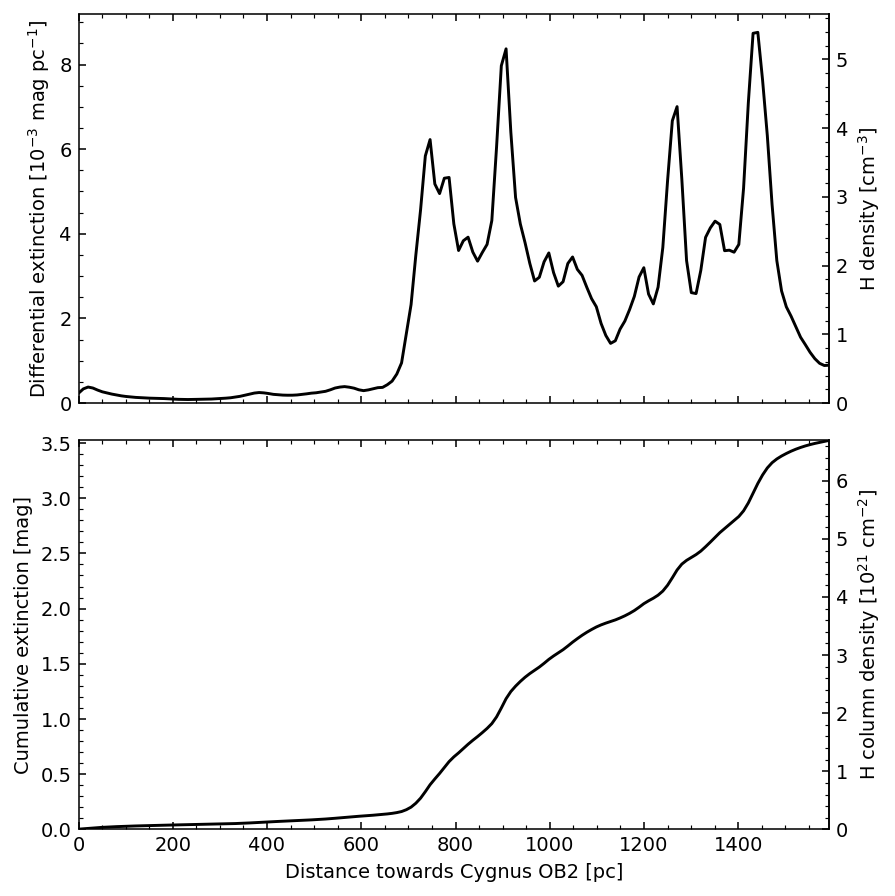

In [106]:
fig, axs = plt.subplots(2, figsize=(6.5, 6.5), sharex=True, tight_layout=True)
# first panel: differential extinction
ax = axs[0]
ax.plot(dist_arr, diff_ext*1e3, 'k-')
ax.tick_params(axis='y', which='both', right=False)
# add secondary axis for ISM density

def diffext2density(x):
    """Extinction density in mmag.pc^-1 to gas density in cm^-3"""
    return x * 1e-3 * gas_to_dust / u.pc.to('cm')

def density2diffext(x):
    """Gas column density in cm^-3 to extinction in mmag.pc^-1"""
    return (x * u.pc.to('cm') / gas_to_dust) * 1e-3

secax = ax.secondary_yaxis('right', functions=(diffext2density, density2diffext))
secax.set_ylabel(r'H density [cm$^{-3}$]')
secax.yaxis.set_minor_locator(MultipleLocator(0.2))
# ax.set_xlabel('Distance towards Cygnus OB2 [pc]')
ax.set_ylabel(r'Differential extinction [$10^{-3}$ mag pc$^{-1}$]')
ax.set_xlim((0, CygOB2_dist))
ax.set_ylim((0, None))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

# second panel: cumulative extinction
ds = dist_arr[1] - dist_arr[0]
ax = axs[1]
ax.plot(dist_arr, np.cumsum(diff_ext * ds), 'k-')
ax.tick_params(axis='y', which='both', right=False)
# add secondary axis for column density

def ext2column(x):
    """Extinction in magnitudes to gas column density in 10^21 cm^-2"""
    return x * (gas_to_dust * 1e-21)

def column2ext(x):
    """Gas column density in 10^21 cm^-2 to extinction in magnitudes"""
    return x / (gas_to_dust * 1e-21)

secax = ax.secondary_yaxis('right', functions=(ext2column, column2ext))
secax.set_ylabel(r'H column density [$10^{21}$ cm$^{-2}$]')
secax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_ylabel('Cumulative extinction [mag]')
ax.set_xlabel('Distance towards Cygnus OB2 [pc]')
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim((0, np.sum(diff_ext * ds)))

plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/CygOB2_linear_extinction.png', dpi=300)
plt.show()

In [73]:
ds = dist_arr[1] - dist_arr[0]
sum(diff_ext * ds)

3.523618532984983

This works great for a single line of sight, but it's way too slow to generate an entire image. Also, the integrated extinction disagrees with the authors' value of 4.2 towards Cygnus OB2.

Nearest-neighbor interpolation

In [55]:
xarr, yarr, zarr = line_of_sight(CygOB2_ra, CygOB2_dec, CygOB2_dist)
dist_arr = np.hypot(xarr-sun_pos[0], yarr-sun_pos[1], zarr-sun_pos[2])*gridstep_pc
diff_ext = data[xarr.astype(int), yarr.astype(int), zarr.astype(int)]

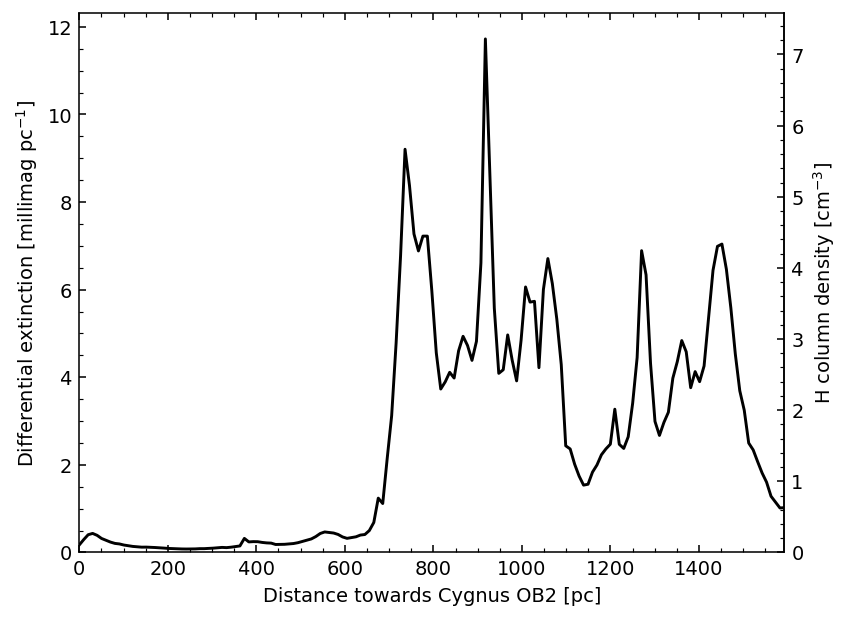

In [56]:
fig, ax = plt.subplots()
ax.plot(dist_arr, diff_ext*1e3, 'k-')
ax.tick_params(axis='y', which='both', right=False)
# add secondary axis for ISM density

def diffext2density(x):
    """Extinction density in mmag.pc^-1 to gas density in cm^-3"""
    return x * 1e-3 * gas_to_dust / u.pc.to('cm')

def density2diffext(x):
    """Gas column density in cm^-3 to extinction in mmag.pc^-1"""
    return (x * u.pc.to('cm') / gas_to_dust) * 1e-3

secax = ax.secondary_yaxis('right', functions=(diffext2density, density2diffext))
secax.set_ylabel(r'H column density [cm$^{-3}$]')
secax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xlabel('Distance towards Cygnus OB2 [pc]')
ax.set_ylabel(r'Differential extinction [millimag pc$^{-1}$]')
ax.set_xlim((0, CygOB2_dist))
ax.set_ylim((0, None))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
plt.savefig('plots/CygOB2_linear_extinction.png', dpi=300)
plt.show()

In [11]:
ds = dist_arr[1] - dist_arr[0]
sum(diff_ext * ds)

4.114002694666851

In [12]:
image_width = 10 # degrees
dx = 0.1 # deg
ra_arr = np.arange(CygOB2_ra - image_width/2, CygOB2_ra + image_width/2 + dx, dx)
dec_arr = np.arange(CygOB2_dec - image_width/2, CygOB2_dec + image_width/2 + dx, dx)
ra_grid, dec_grid = np.meshgrid(ra_arr, dec_arr)
print(ra_grid.shape)

(102, 102)


In [13]:
ds = dist_arr[1] - dist_arr[0]

extinctions = []
for ra, dec in zip(ra_grid.flatten(), dec_grid.flatten()):
    xarr, yarr, zarr = line_of_sight(ra, dec, CygOB2_dist)
    diff_ext = data[xarr.astype(int), yarr.astype(int), zarr.astype(int)]
    extinctions.append(sum(diff_ext * ds))
    
extinctions = np.reshape(np.array(extinctions), ra_grid.shape)

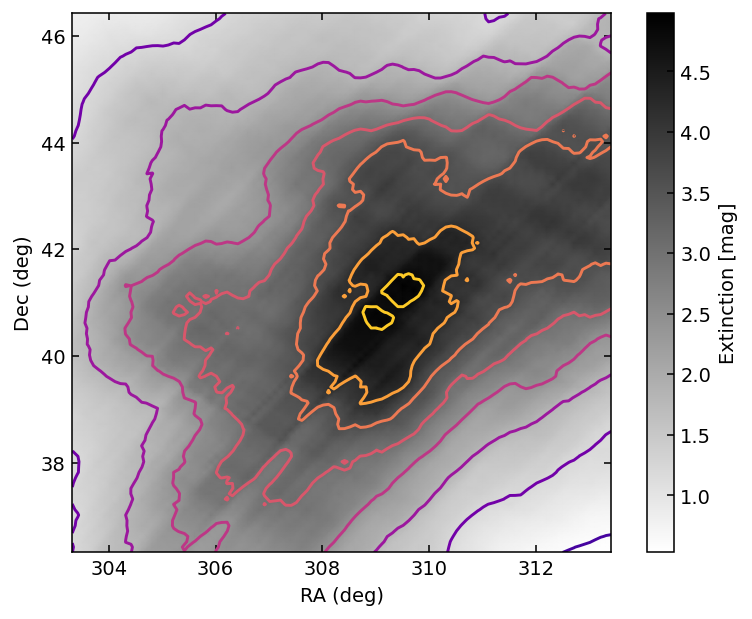

In [14]:
fig, ax = plt.subplots()
qm = ax.pcolormesh(ra_grid, dec_grid, extinctions, shading='gouraud', cmap='binary')
ax.contour(ra_grid, dec_grid, extinctions, cmap='plasma')
plt.colorbar(qm, ax=ax, label='Extinction [mag]')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_aspect('equal')
plt.show()

Smooth with a Gaussian KDE

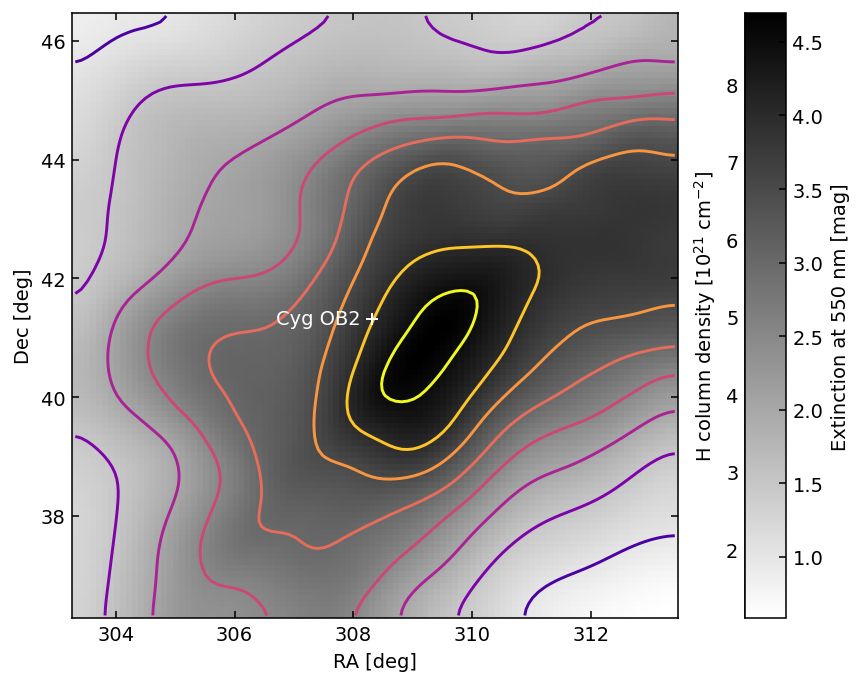

In [37]:
# smooth line-of-sight integrated extinctions with a width of 3 pixels
ext_smooth = ndimage.gaussian_filter(extinctions, sigma=(3, 3), order=0)
contour_levels = np.arange(0.5, 5, 0.5)
fig, ax = plt.subplots(figsize=(6.5, 5), dpi=140, tight_layout=True)
qm = ax.pcolormesh(ra_grid, dec_grid, ext_smooth, cmap='binary')
ax.contour(ra_grid, dec_grid, ext_smooth, cmap='plasma', levels=contour_levels)
ax.plot([CygOB2_ra], [CygOB2_dec], 'w+')
ax.text(CygOB2_ra-0.2, CygOB2_dec, 'Cyg OB2', color='w', ha='right', va='center')
cbar = plt.colorbar(qm, ax=ax, label='Extinction at 550 nm [mag]', pad=0.08, aspect=15)
cbar.ax.tick_params(axis='y', which='both', left=False)

def ext2column(x):
    """Extinction in magnitudes to gas column density in 10^21 cm^-2"""
    return x * (gas_to_dust * 1e-21)

def column2ext(x):
    """Gas column density in 10^21 cm^-2 to extinction in magnitudes"""
    return x / (gas_to_dust * 1e-21)

secax = cbar.ax.secondary_yaxis('left', functions=(ext2column, column2ext))
secax.set_ylabel(r'H column density [$10^{21}$ cm$^{-2}$]')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_aspect('equal')
plt.savefig('plots/CygOB2_ext_map_smooth.png', dpi=300)
plt.show()

In [16]:
# save integrated extinction as fits file
img_hdu = fits.PrimaryHDU(ext_smooth)
img_hdu.header.update({
    'CTYPE1':  ('RA---SIN', 'Orthographic Projection'),
    'CTYPE2':  ('DEC--SIN', 'Orthographic Projection'),
    'CRPIX1':  (50, 'Axis 1 Reference Pixel'),
    'CRPIX2':  (50, 'Axis 2 Reference Pixel'),
    'CRVAL1':  (CygOB2_ra,  'RA  at Frame Center, J2000 (deg)'),
    'CRVAL2':  (CygOB2_dec, 'Dec at Frame Center, J2000 (deg)'),
    'CDELT1': (dx, 'Axis 1 Pixel Size (deg)'),
    'CDELT2': (dx, 'Axis 2 Pixel Size (deg)'),
    'CUNIT1':  ('deg', 'Units of coordinate increment and value'),
    'CUNIT2':  ('deg', 'Units of coordinate increment and value'),
    'RADESYS': ('ICRS', 'Equatorial coordinate system'),
})
hdul = fits.HDUList([img_hdu])
hdul.writeto('output/CygOB2_intext_smooth.fits', overwrite=True)
img_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  102                                                  
NAXIS2  =                  102                                                  
EXTEND  =                    T                                                  
CTYPE1  = 'RA---SIN'           / Orthographic Projection                        
CTYPE2  = 'DEC--SIN'           / Orthographic Projection                        
CRPIX1  =                   50 / Axis 1 Reference Pixel                         
CRPIX2  =                   50 / Axis 2 Reference Pixel                         
CRVAL1  =              308.317 / RA  at Frame Center, J2000 (deg)               
CRVAL2  =                41.32 / Dec at Frame Center, J2000 (deg)               
CDELT1  =                  0

TODO: save as fits image

In [17]:
ra_full = ra_grid.flatten()[:,np.newaxis]
dec_full = dec_grid.flatten()[:,np.newaxis]
coord_grid = np.hstack((ra_full, 
                        dec_full, 
                        CygOB2_dist * np.ones(ra_full.shape)))
np.savetxt('output/CygOB2_coords.csv', coord_grid, delimiter=',', header='ra,dec,dist')

In [18]:
intext = np.loadtxt('data/CygOB2_intext.csv', delimiter=',', skiprows=1)
intext

array([[3.03317e+02, 3.63200e+01, 1.59300e+03, 1.26188e+00, 5.86000e-03],
       [3.03417e+02, 3.63200e+01, 1.59300e+03, 1.31822e+00, 5.93000e-03],
       [3.03517e+02, 3.63200e+01, 1.59300e+03, 1.37677e+00, 6.05000e-03],
       ...,
       [3.13217e+02, 4.64200e+01, 1.59300e+03, 1.60134e+00, 6.70000e-03],
       [3.13317e+02, 4.64200e+01, 1.59300e+03, 1.61813e+00, 6.67000e-03],
       [3.13417e+02, 4.64200e+01, 1.59300e+03, 1.63569e+00, 6.63000e-03]])

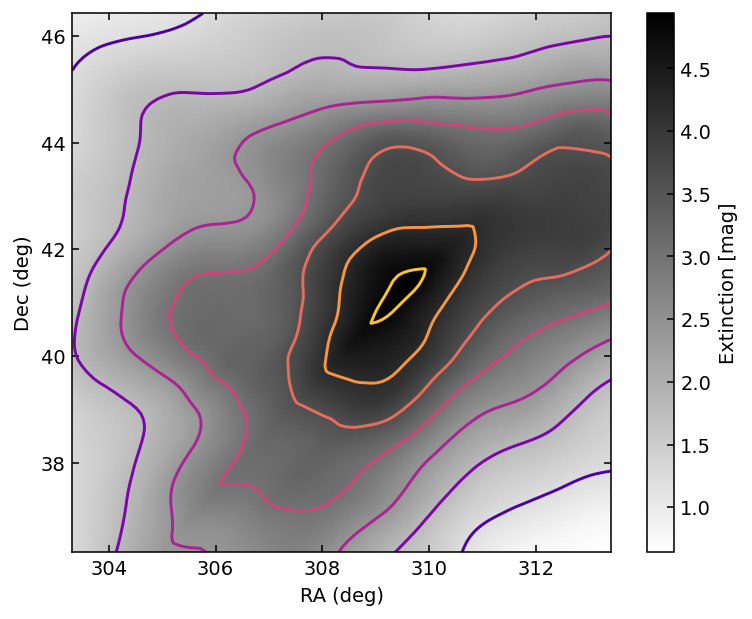

In [19]:
fig, ax = plt.subplots()
qm = ax.pcolormesh(ra_grid, dec_grid, intext[:,3].reshape(ra_grid.shape), shading='gouraud', cmap='binary')
ax.contour(ra_grid, dec_grid, intext[:,3].reshape(ra_grid.shape), cmap='plasma')
plt.colorbar(qm, ax=ax, label='Extinction [mag]')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_aspect('equal')
plt.show()

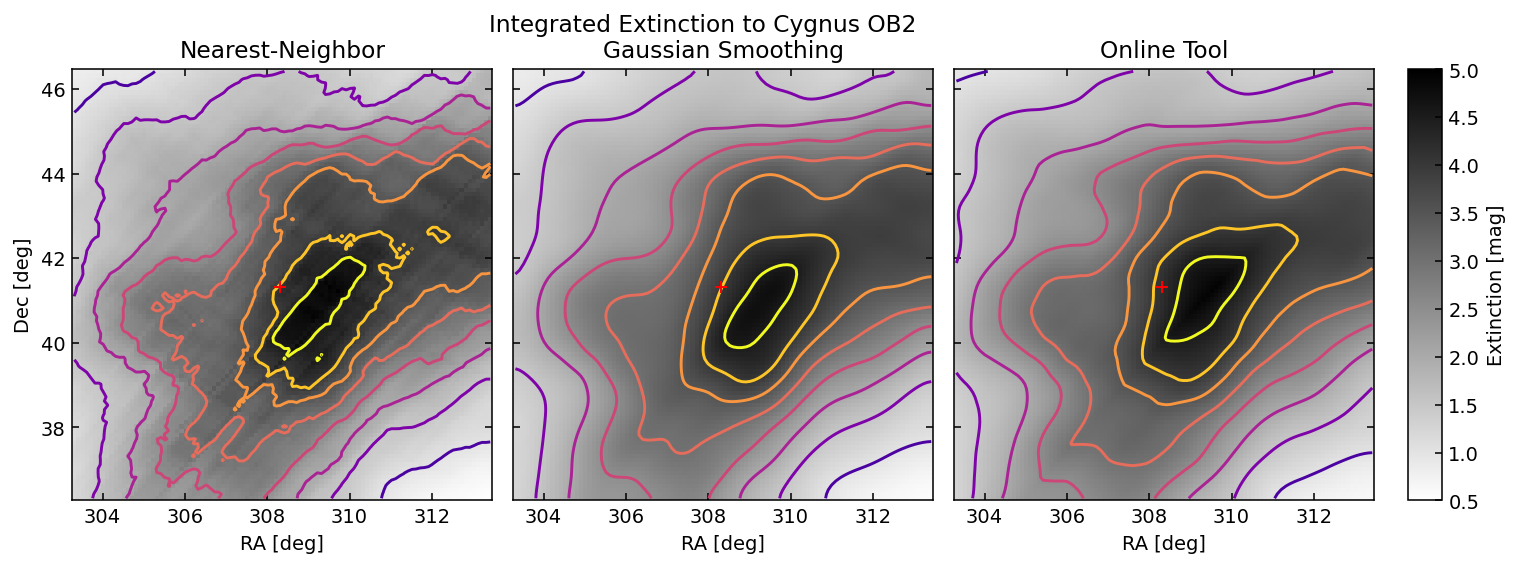

In [20]:
norm = Normalize(vmin=0.5, vmax=5.)
cmap = 'binary'
cmap_contour = 'plasma'
contour_levels = np.arange(0.5, 5, 0.5)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

axs[0].pcolormesh(ra_grid, dec_grid, extinctions, cmap=cmap, norm=norm)
axs[0].contour(ra_grid, dec_grid, extinctions, cmap=cmap_contour, levels=contour_levels)
axs[0].plot([CygOB2_ra], [CygOB2_dec], 'r+')
axs[0].set_title('Nearest-Neighbor')
axs[0].set_xlabel('RA [deg]')
axs[0].set_ylabel('Dec [deg]')

ext_smooth = ndimage.gaussian_filter(extinctions, sigma=(2.5, 2.5), order=0)
axs[1].pcolormesh(ra_grid, dec_grid, ext_smooth, cmap=cmap, norm=norm)
axs[1].contour(ra_grid, dec_grid, ext_smooth, cmap=cmap_contour, levels=contour_levels)
axs[1].plot([CygOB2_ra], [CygOB2_dec], 'r+')
axs[1].set_title('Gaussian Smoothing')
axs[1].set_xlabel('RA [deg]')

axs[2].pcolormesh(ra_grid, dec_grid, intext[:,3].reshape(ra_grid.shape), cmap=cmap, norm=norm)
axs[2].contour(ra_grid, dec_grid, intext[:,3].reshape(ra_grid.shape), cmap=cmap_contour, levels=contour_levels)
axs[2].plot([CygOB2_ra], [CygOB2_dec], 'r+')
axs[2].set_title('Online Tool')
axs[2].set_xlabel('RA [deg]')

fig.subplots_adjust(wspace=0.05, right=0.9)
cax = plt.axes([0.92, 0.11, 0.02, 0.77])
cbar = fig.colorbar(ScalarMappable(norm, cmap), cax, label='Extinction [mag]')

fig.suptitle('Integrated Extinction to Cygnus OB2')
plt.show()